In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**lOADING THE SUBJECTS**

In [7]:
import pickle
import os
data_dict = {}

for dirname, _, filenames in os.walk(r"D:\3rd year 2nd semster\Signal processing\WESAD\WESAD.pkl"):
    for filename in filenames:
        if filename.endswith('.pkl'):
            file_path = os.path.join(dirname, filename)
            subject_id = os.path.basename(filename).split('.')[0]  # 'S2', 'S3', ...
            with open(file_path, 'rb') as f:
                data_dict[subject_id] = pickle.load(f, encoding='latin1')  # FIXED

print("Loaded subjects:", list(data_dict.keys()))

Loaded subjects: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']


**IMPORTING LIBRARIES**

In [9]:
!pip install biosppy

Defaulting to user installation because normal site-packages is not writeable


In [10]:
!pip install peakutils

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import pickle
import biosppy
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

****Checking available signals****

In [13]:
sample_subject = next(iter(data_dict.values()))

chest_keys = sample_subject['signal'].get('chest', {}).keys()
wrist_keys = sample_subject['signal'].get('wrist', {}).keys()

print("Chest sensor channels:", list(chest_keys))
print("Wrist sensor channels:", list(wrist_keys))

Chest sensor channels: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
Wrist sensor channels: ['ACC', 'BVP', 'EDA', 'TEMP']


**Making Sure all subjects are loaded correctly**

In [15]:
print("Loaded subjects:", sorted(data_dict.keys()))

Loaded subjects: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']


In [16]:
valid_labels = {1, 2, 3}

for subject_id, subject_data in data_dict.items():
    eda = subject_data['signal']['chest']['EDA']
    label = subject_data['label']

    print(f"\nSubject {subject_id}:")

    # 1. Check matching lengths
    if eda.shape[0] != label.shape[0]:
        print("Length mismatch between EDA and labels.")
        continue

    # 2. Check for NaNs
    if np.isnan(eda).any() or np.isnan(label).any():
        print("NaN values found.")
        continue

    # 3. Check label classes
    unique_labels = set(np.unique(label))
    if not unique_labels.issubset(valid_labels):
        print(f"Unexpected labels found: {unique_labels}")
    else:
        print(f"Labels OK: {unique_labels}")

    # 4. Basic stats on EDA
    print(f"EDA shape: {eda.shape}, min: {np.min(eda)}, max: {np.max(eda)}, mean: {np.mean(eda):.2f}")



Subject S10:
Unexpected labels found: {0, 1, 2, 3, 4, 5, 6, 7}
EDA shape: (3847200, 1), min: 0.4161834716796875, max: 2.2579193115234375, mean: 1.28

Subject S11:
Unexpected labels found: {0, 1, 2, 3, 4, 5, 6, 7}
EDA shape: (3663100, 1), min: 5.6262969970703125, max: 8.166885375976562, mean: 6.50

Subject S13:
Unexpected labels found: {0, 1, 2, 3, 4, 5, 6, 7}
EDA shape: (3875900, 1), min: 2.0267486572265625, max: 6.635284423828125, mean: 3.17

Subject S14:
Unexpected labels found: {0, 1, 2, 3, 4, 5, 6, 7}
EDA shape: (3883600, 1), min: 2.4669647216796875, max: 3.261566162109375, mean: 2.93

Subject S15:
Unexpected labels found: {0, 1, 2, 3, 4, 5, 6, 7}
EDA shape: (3676400, 1), min: 1.2500762939453125, max: 4.3182373046875, mean: 2.91

Subject S16:
Unexpected labels found: {0, 1, 2, 3, 4, 5, 6, 7}
EDA shape: (3941700, 1), min: 0.6374359130859375, max: 5.5004119873046875, mean: 2.14

Subject S17:
Unexpected labels found: {0, 1, 2, 3, 4, 5, 6, 7}
EDA shape: (4144000, 1), min: 5.0575256347

Raw Signal Visualization

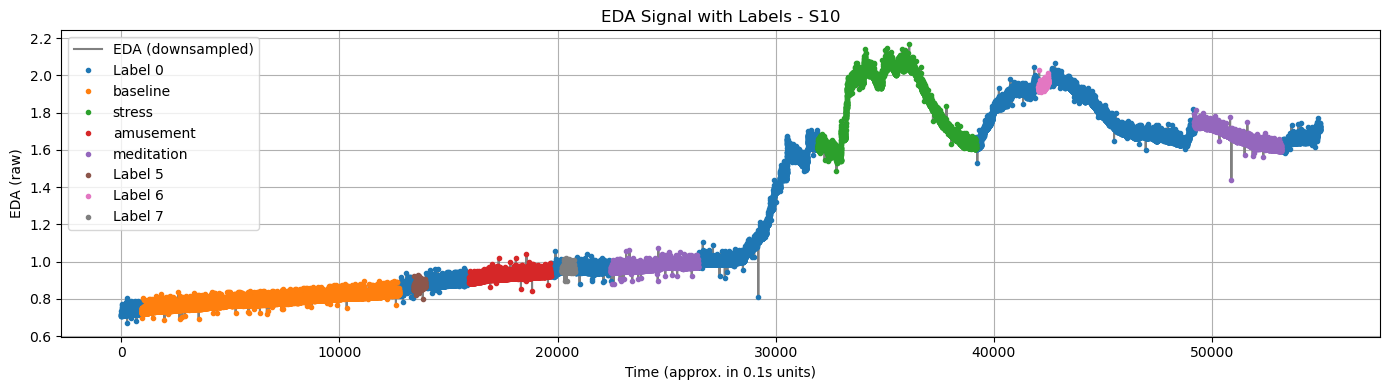

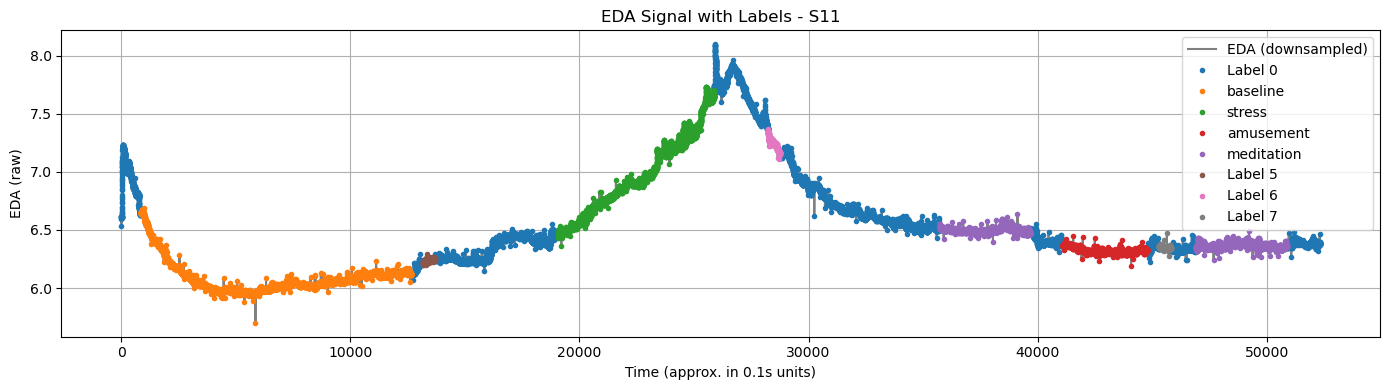

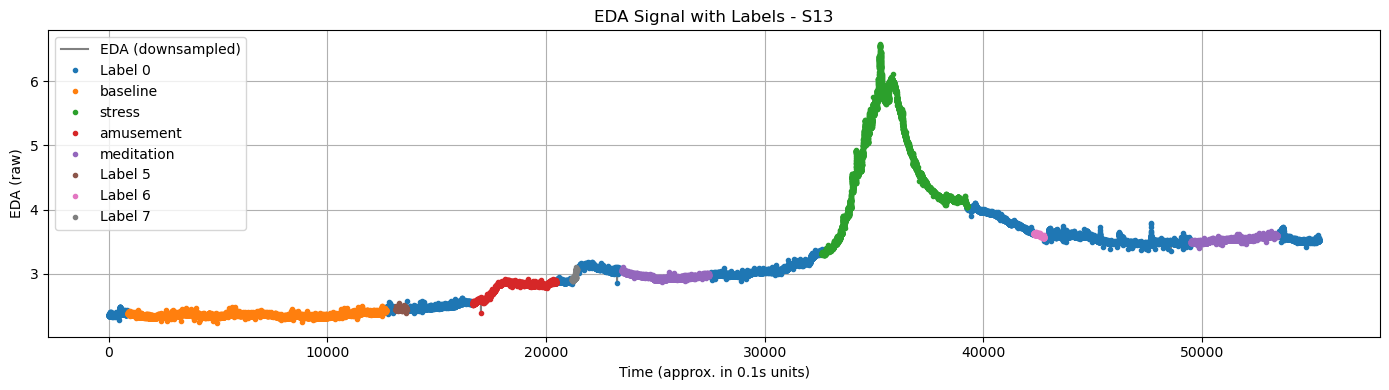

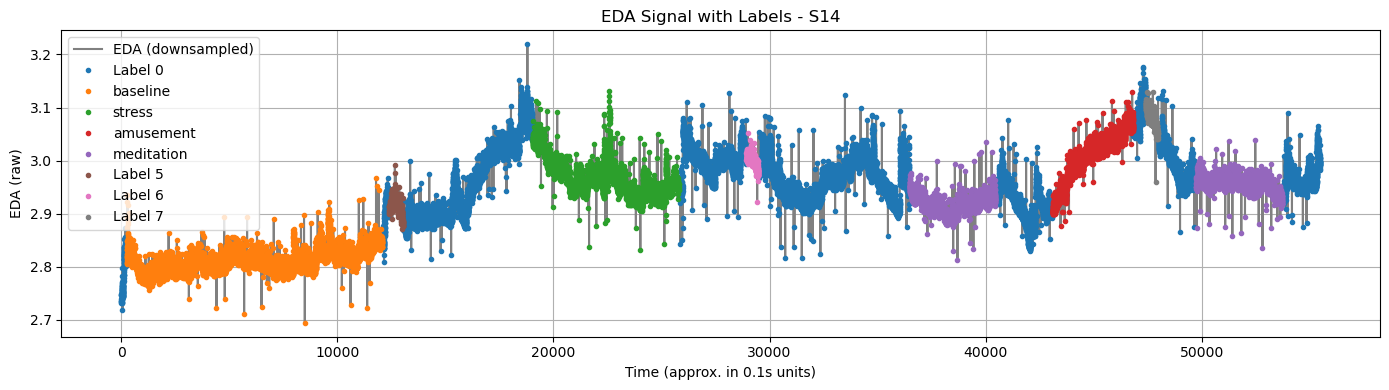

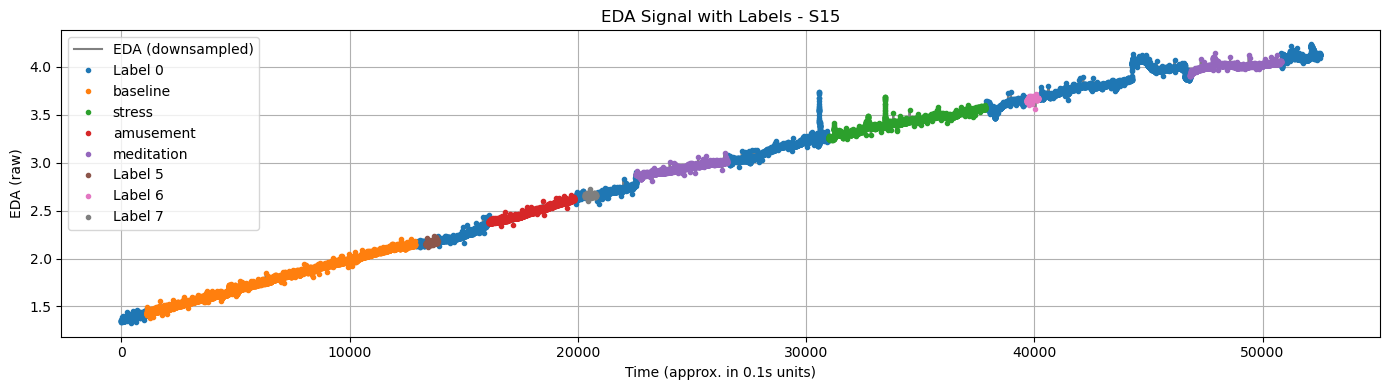

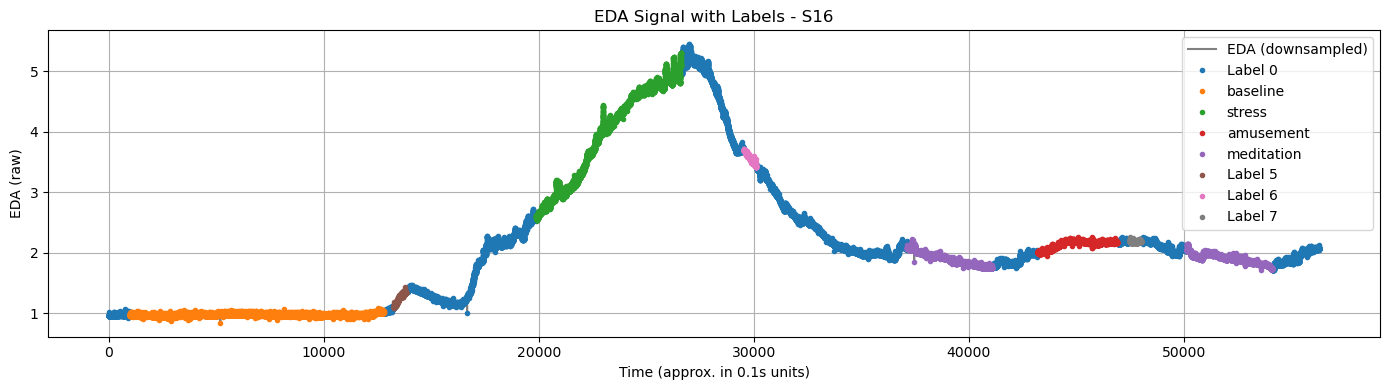

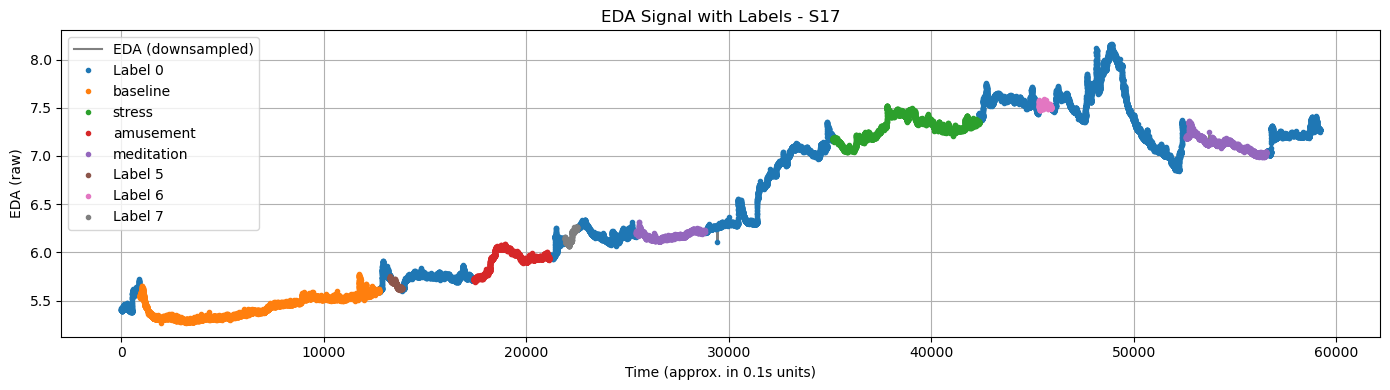

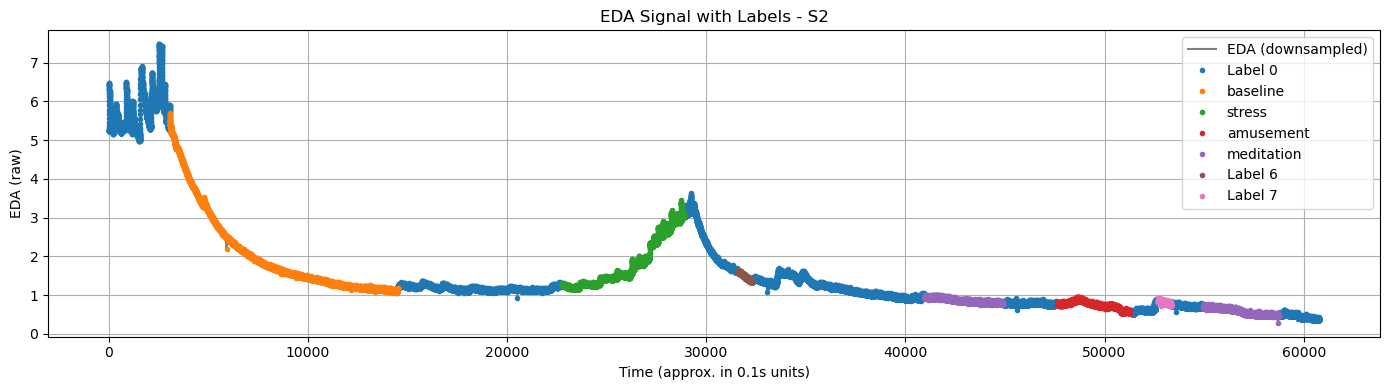

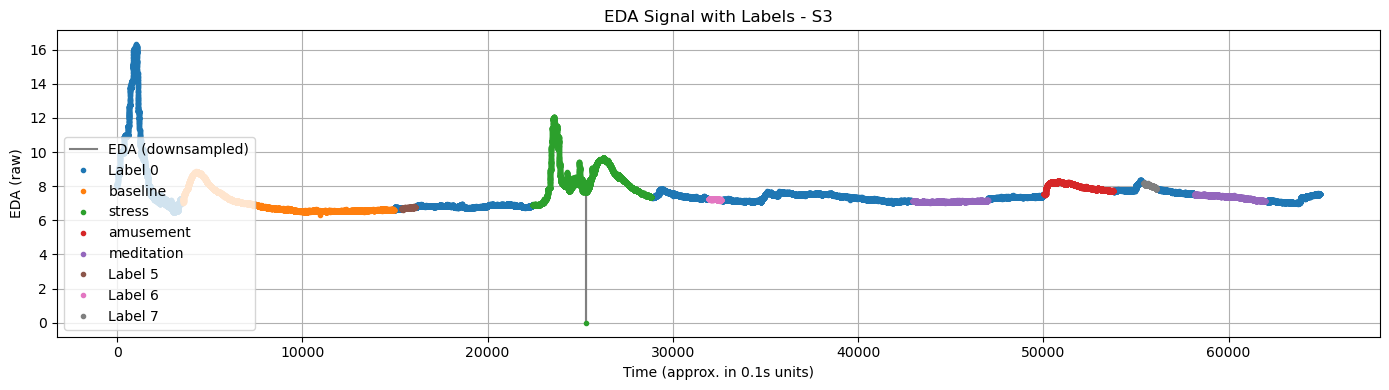

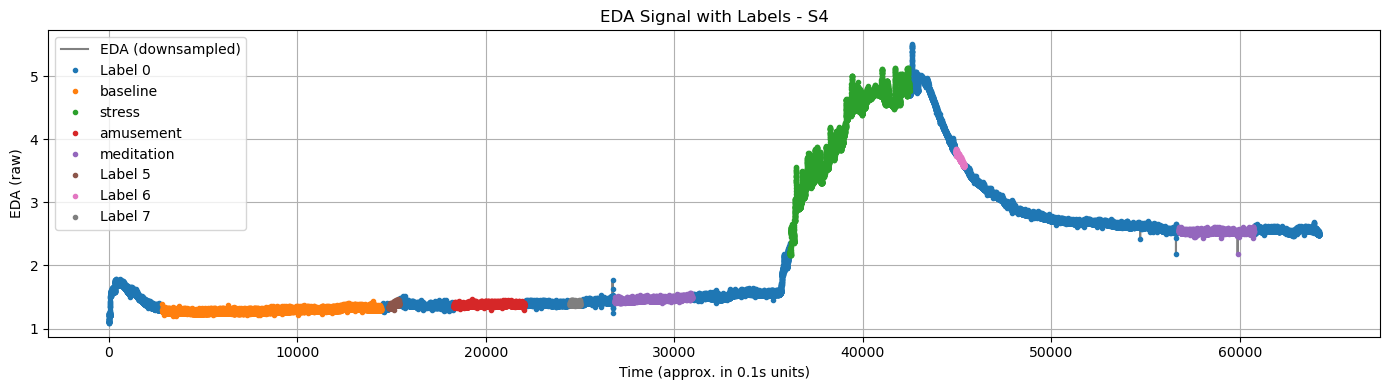

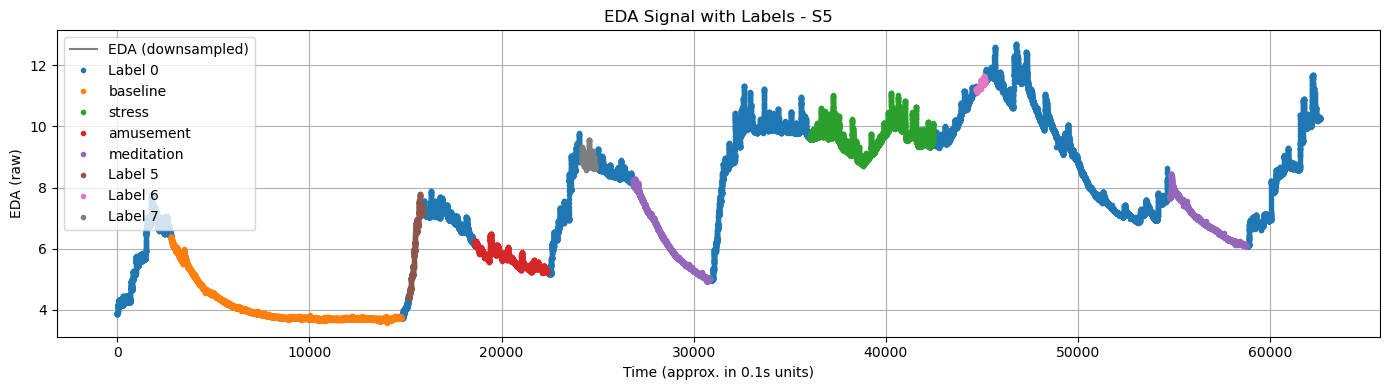

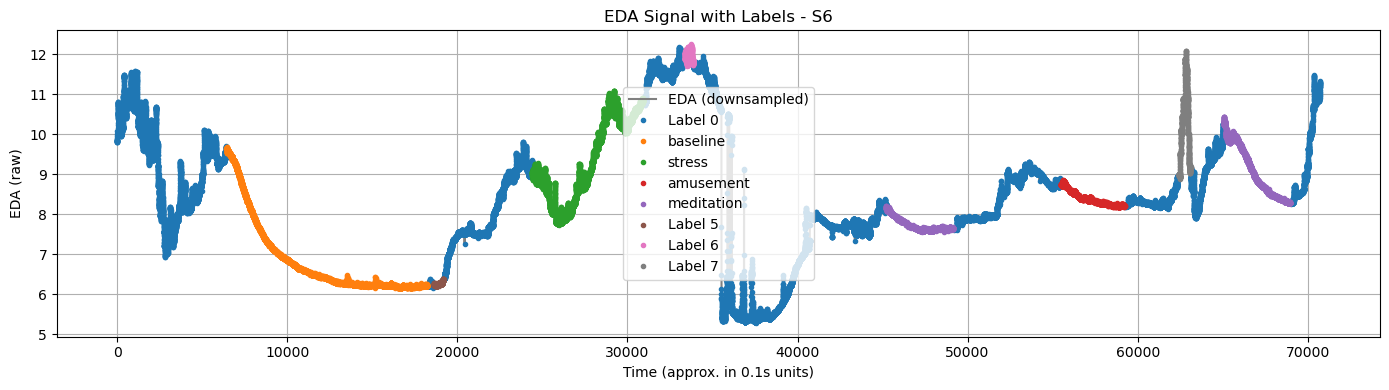

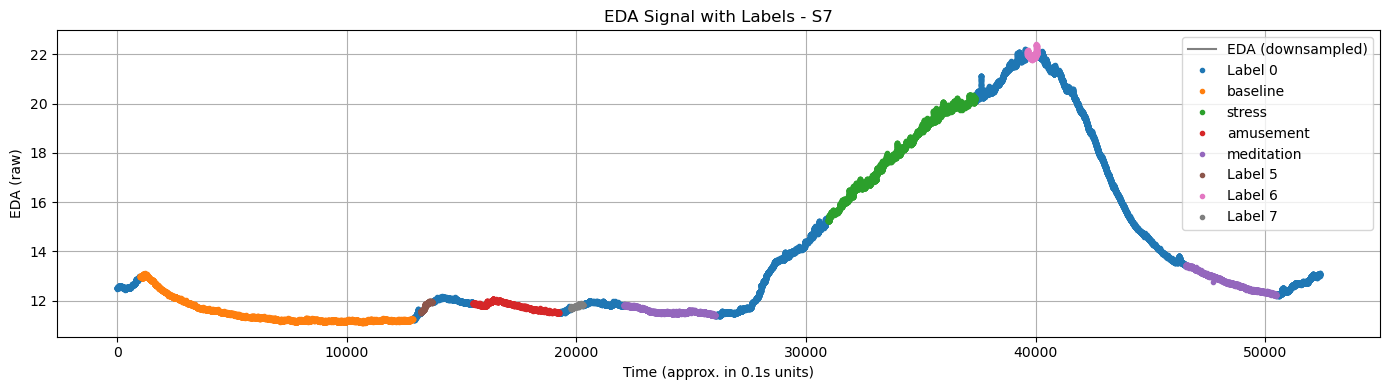

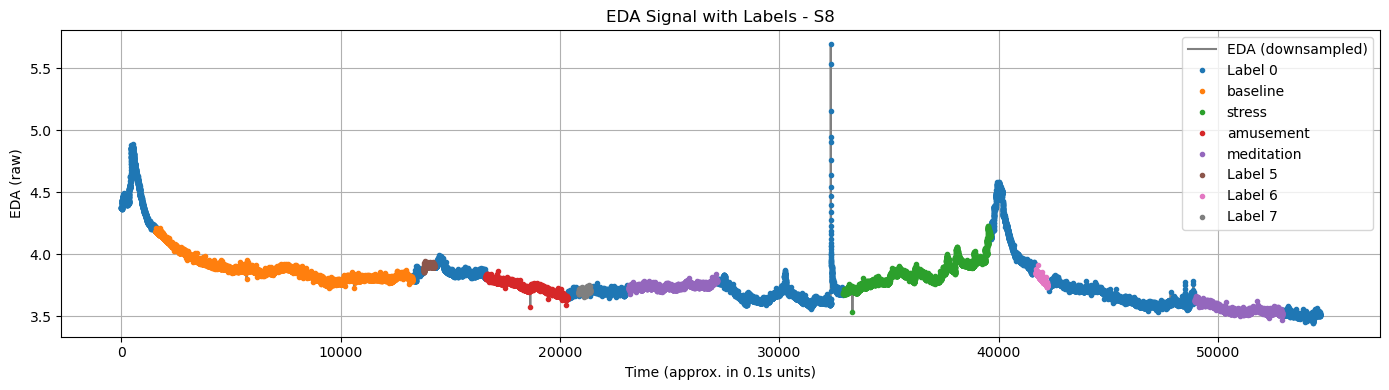

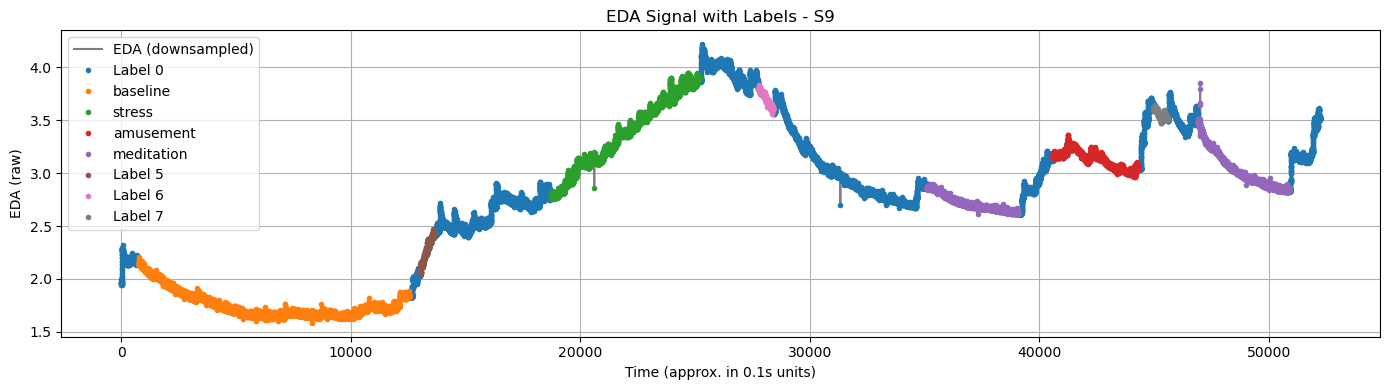

In [17]:
import numpy as np
import matplotlib.pyplot as plt

label_map = {1: 'baseline', 2: 'stress', 3: 'amusement', 4:'meditation'}

for subject_id in sorted(data_dict.keys()):
    subject_data = data_dict[subject_id]

    # Extract EDA and labels
    eda_signal = subject_data['signal']['chest']['EDA']
    labels = subject_data['label']

    # Downsample to ~10Hz for faster plotting
    step = 70
    eda_downsampled = eda_signal[::step]
    labels_downsampled = labels[::step]

    plt.figure(figsize=(14, 4))
    plt.plot(eda_downsampled, color='gray', label='EDA (downsampled)')

    for label_value in np.unique(labels_downsampled):
        idx = labels_downsampled == label_value
        plt.plot(np.where(idx)[0], eda_downsampled[idx], '.', 
                 label=label_map.get(label_value, f'Label {label_value}'))

    plt.title(f'EDA Signal with Labels - {subject_id}')
    plt.xlabel('Time (approx. in 0.1s units)')
    plt.ylabel('EDA (raw)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Removing unwanted labels and visualize the remaining ones

In [18]:
# Define valid labels for classification
valid_labels = [1, 2, 3]

# Create a new cleaned dictionary
cleaned_data_dict = {}

for subject_id, subject_data in data_dict.items():
    eda = subject_data['signal']['chest']['EDA']
    labels = subject_data['label']

    # Flatten EDA if it's (N,1)
    if eda.ndim == 2 and eda.shape[1] == 1:
        eda = eda.flatten()

    # Get mask of valid label indices
    valid_idx = np.isin(labels, valid_labels)

    # Filter EDA and labels
    eda_cleaned = eda[valid_idx]
    labels_cleaned = labels[valid_idx]

    # Save cleaned data
    cleaned_data_dict[subject_id] = {
        'EDA': eda_cleaned,
        'label': labels_cleaned
    }

    print(f"Cleaned {subject_id}: {len(labels_cleaned)} samples kept")


Cleaned S10: 1593900 samples kept
Cleaned S11: 1559600 samples kept
Cleaned S13: 1558201 samples kept
Cleaned S14: 1558901 samples kept
Cleaned S15: 1563100 samples kept
Cleaned S16: 1554701 samples kept
Cleaned S17: 1593200 samples kept
Cleaned S2: 1484700 samples kept
Cleaned S3: 1508500 samples kept
Cleaned S4: 1515501 samples kept
Cleaned S5: 1551900 samples kept
Cleaned S6: 1541400 samples kept
Cleaned S7: 1538601 samples kept
Cleaned S8: 1546299 samples kept
Cleaned S9: 1537900 samples kept


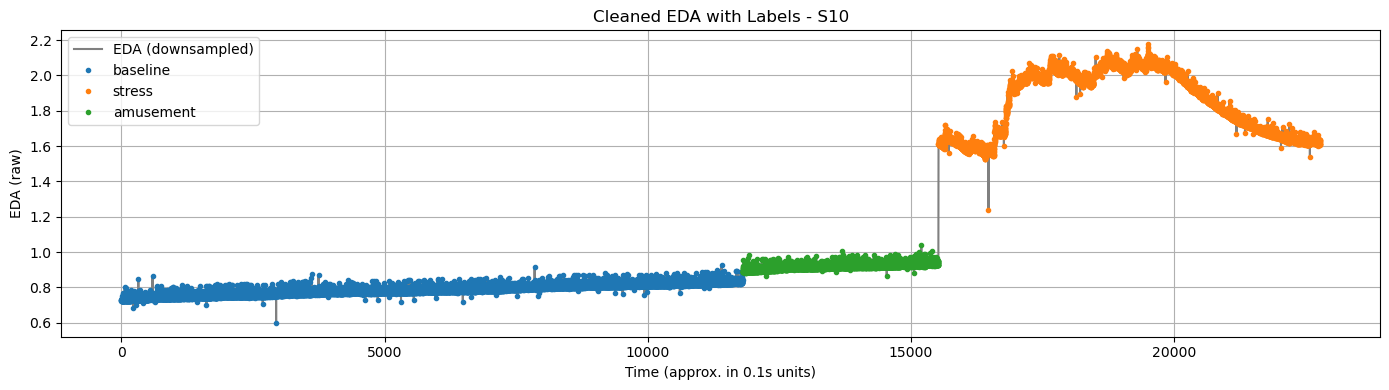

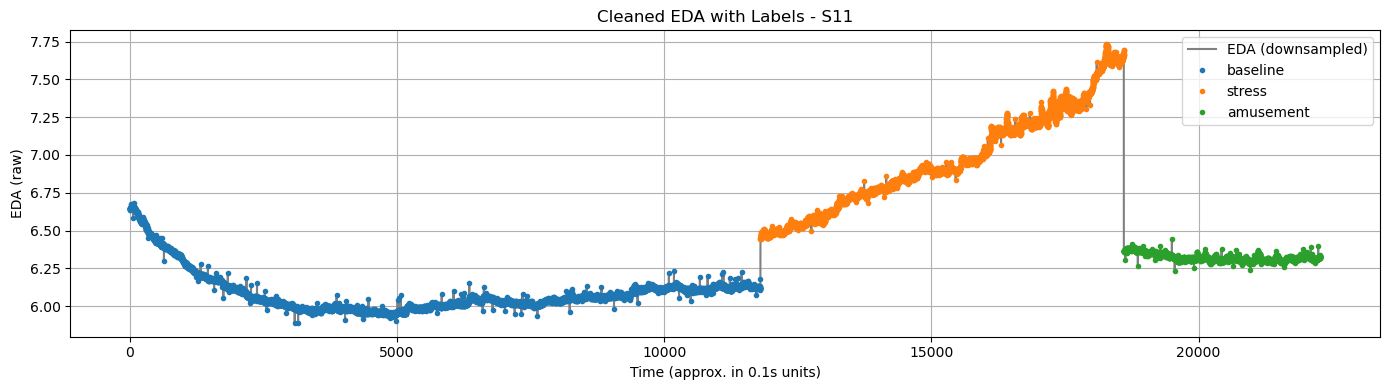

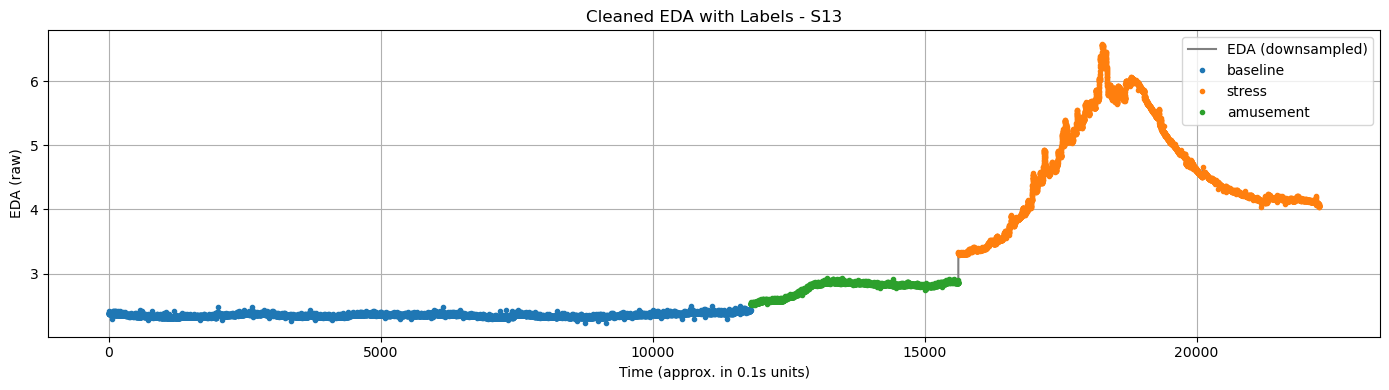

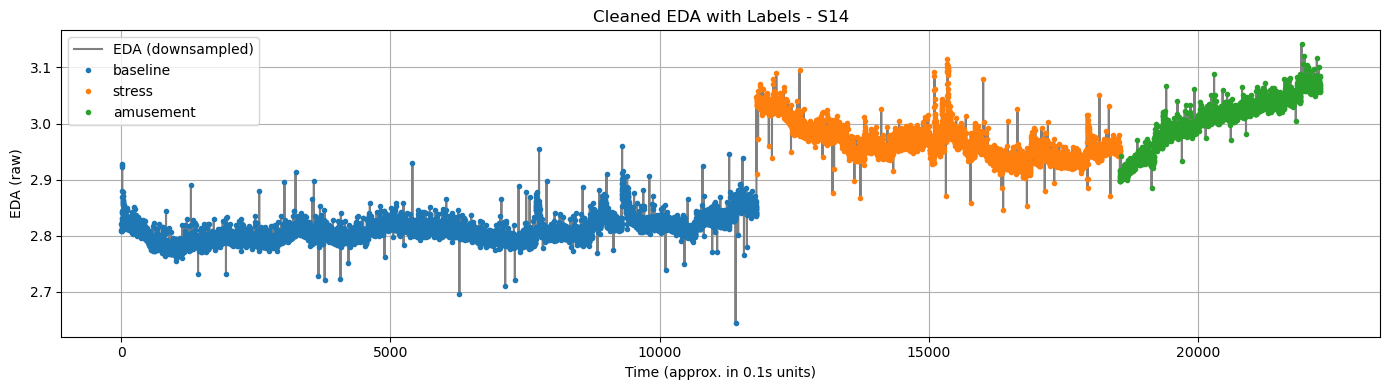

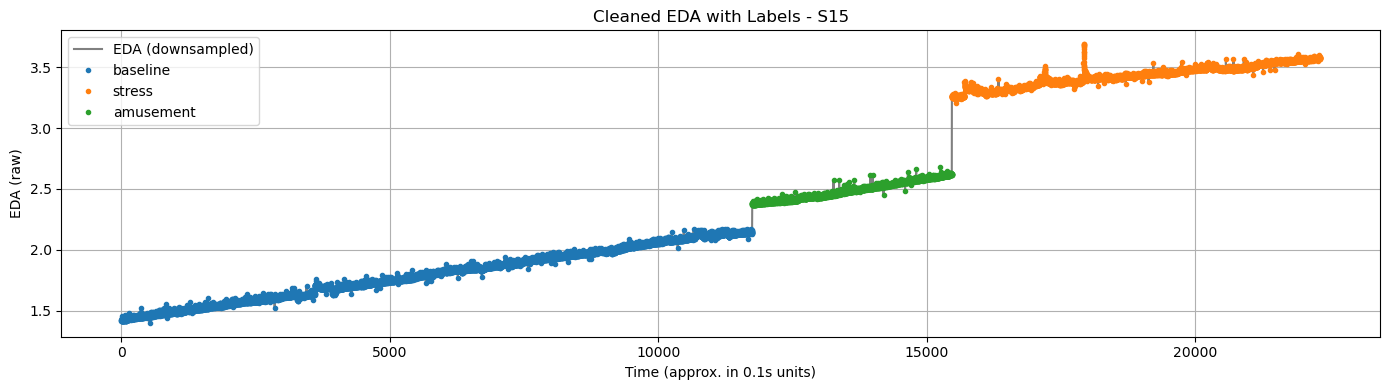

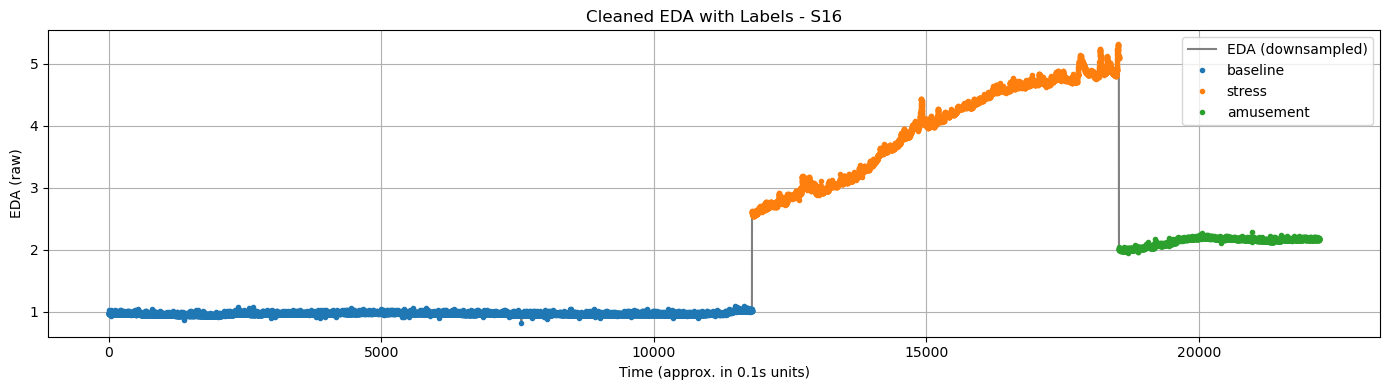

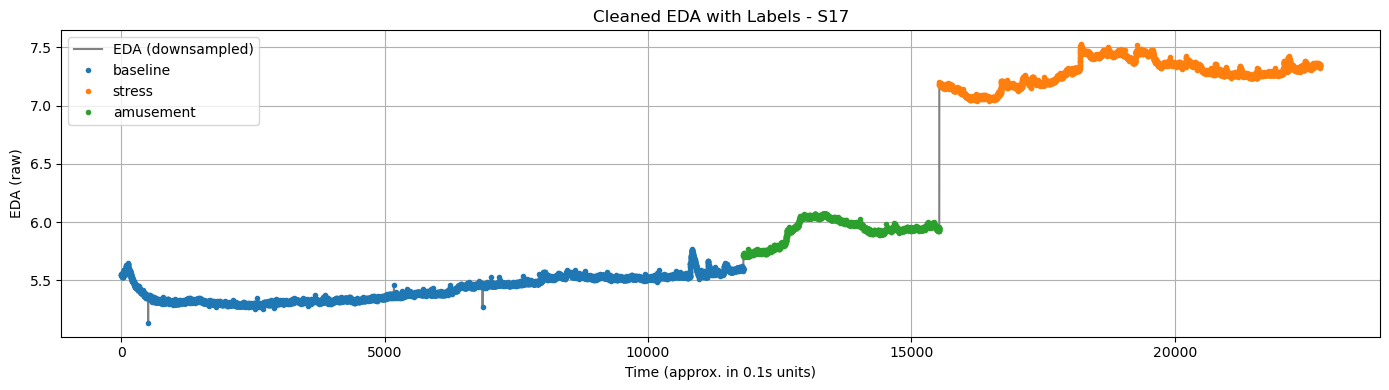

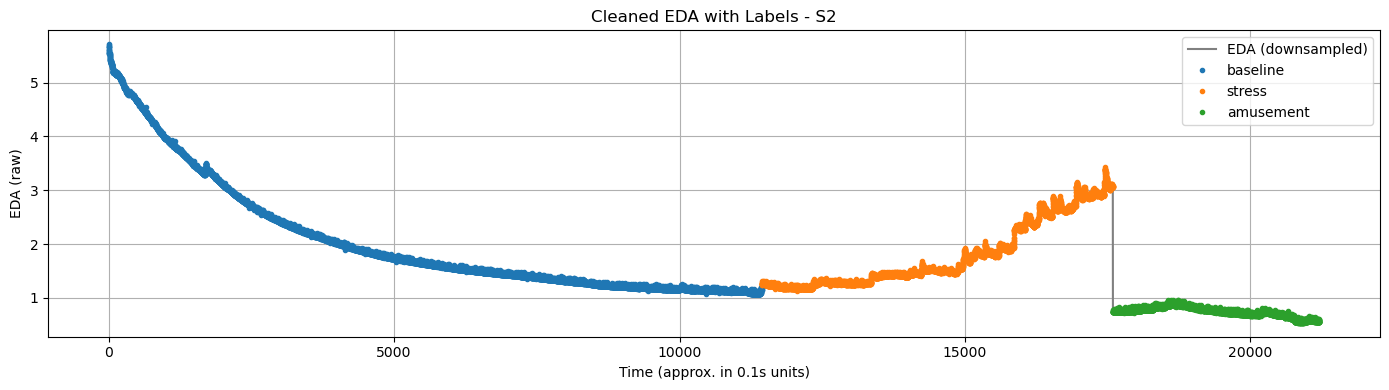

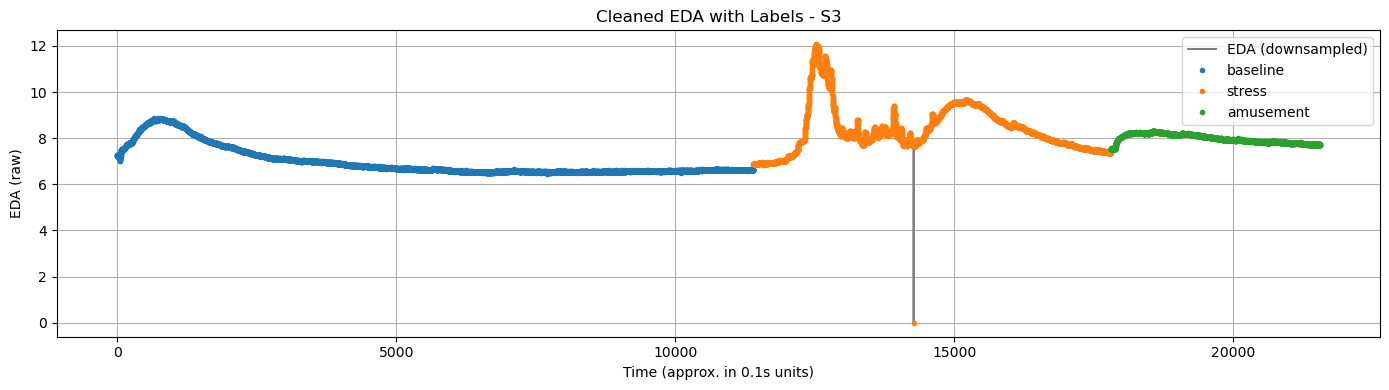

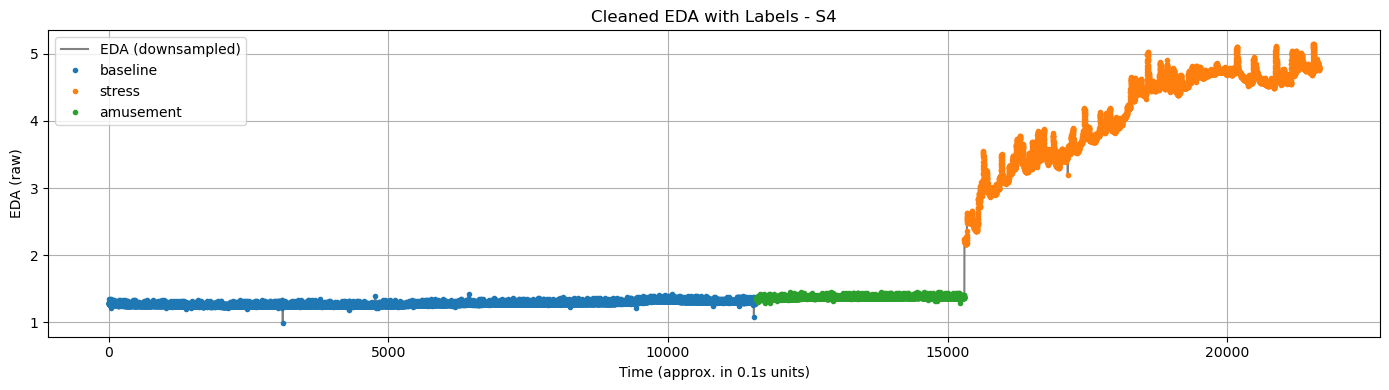

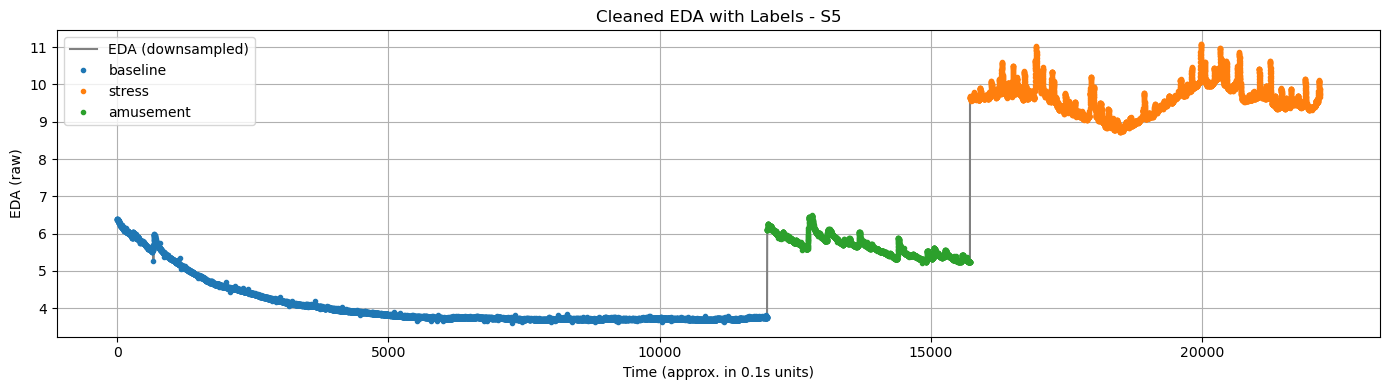

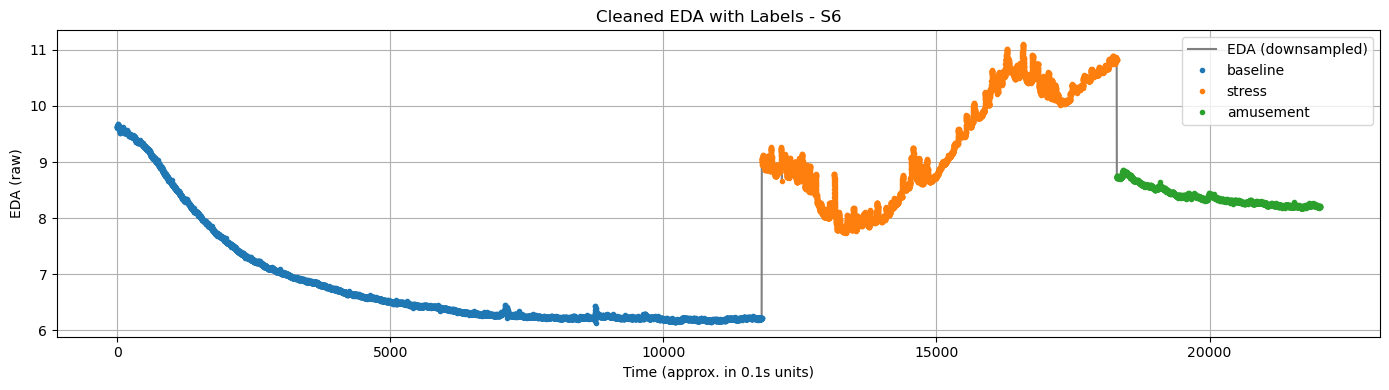

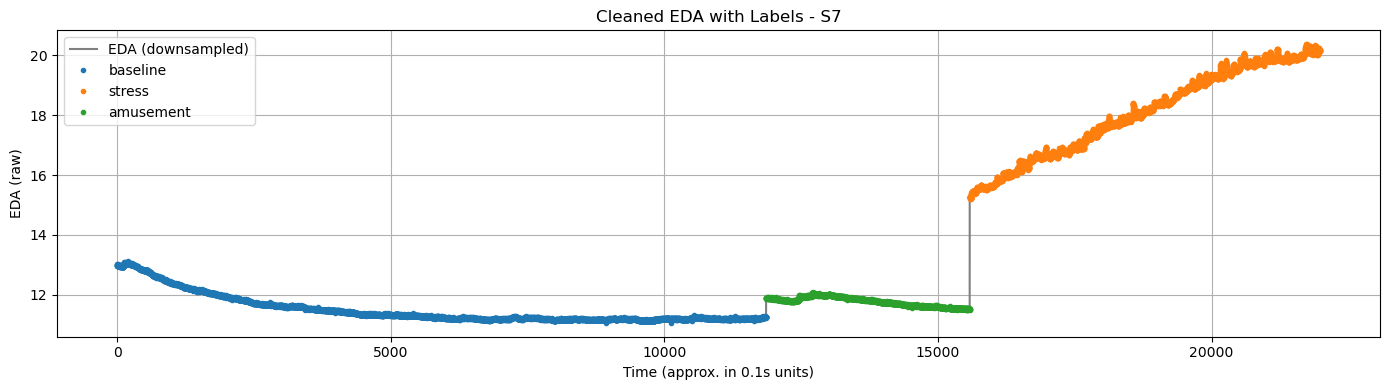

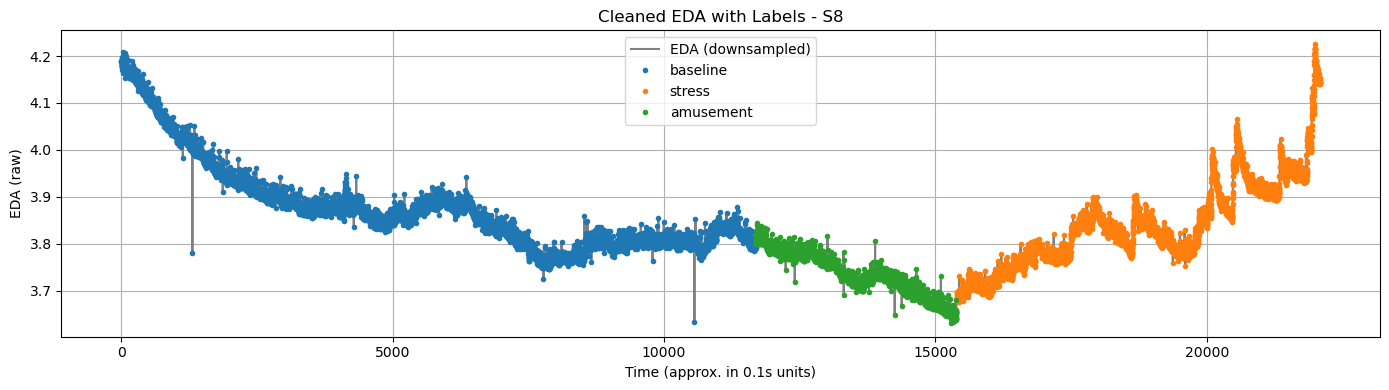

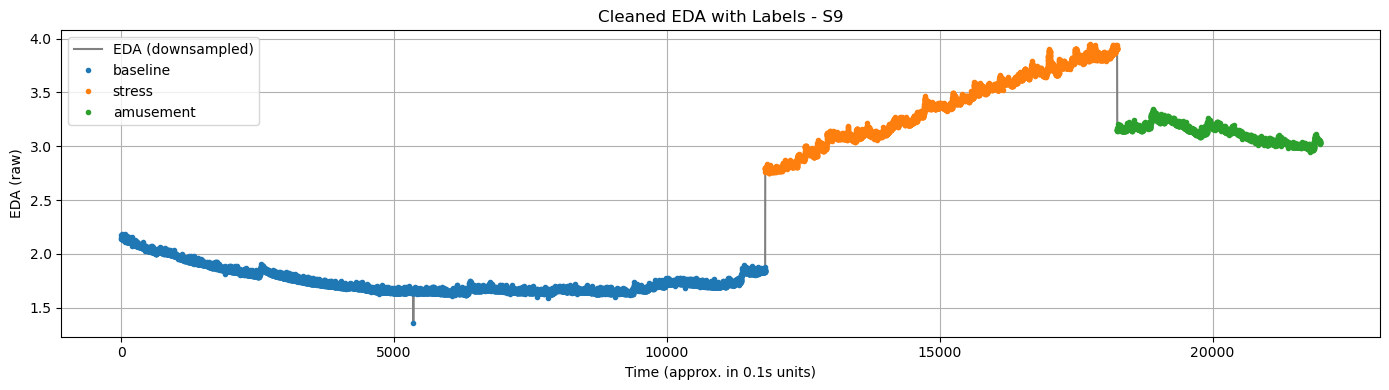

In [19]:
# Label mapping
label_map = {1: 'baseline', 2: 'stress', 3: 'amusement'}

for subject_id, data in cleaned_data_dict.items():
    eda = data['EDA']
    labels = data['label']

    # Downsample to ~10 Hz
    step = 70
    eda_ds = eda[::step]
    labels_ds = labels[::step]

    plt.figure(figsize=(14, 4))
    plt.plot(eda_ds, color='gray', label='EDA (downsampled)')

    for label_value in np.unique(labels_ds):
        idx = labels_ds == label_value
        plt.plot(np.where(idx)[0], eda_ds[idx], '.', label=label_map.get(label_value, f'Label {label_value}'))

    plt.title(f'Cleaned EDA with Labels - {subject_id}')
    plt.xlabel('Time (approx. in 0.1s units)')
    plt.ylabel('EDA (raw)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
valid_labels = {1, 2, 3}

for subject_id, data in cleaned_data_dict.items():
    eda = data['EDA']
    labels = data['label']

    print(f"\nSubject {subject_id}:")

    if eda.shape[0] != labels.shape[0]:
        print("Length mismatch between EDA and labels.")
        continue

    if np.isnan(eda).any() or np.isnan(labels).any():
        print("NaN values found.")
        continue

    unique_labels = set(np.unique(labels))
    if not unique_labels.issubset(valid_labels):
        print(f"Unexpected labels: {unique_labels}")
    else:
        print(f"Labels OK: {unique_labels}")

    print(f"EDA shape: {eda.shape}, min: {np.min(eda):.3f}, max: {np.max(eda):.3f}, mean: {np.mean(eda):.3f}")



Subject S10:
Labels OK: {1, 2, 3}
EDA shape: (1593900,), min: 0.453, max: 2.258, mean: 1.145

Subject S11:
Labels OK: {1, 2, 3}
EDA shape: (1559600,), min: 5.626, max: 7.780, mean: 6.394

Subject S13:
Labels OK: {1, 2, 3}
EDA shape: (1558201,), min: 2.027, max: 6.635, mean: 3.095

Subject S14:
Labels OK: {1, 2, 3}
EDA shape: (1558901,), min: 2.467, max: 3.185, mean: 2.888

Subject S15:
Labels OK: {1, 2, 3}
EDA shape: (1563100,), min: 1.315, max: 3.709, mean: 2.412

Subject S16:
Labels OK: {1, 2, 3}
EDA shape: (1554701,), min: 0.637, max: 5.368, mean: 2.063

Subject S17:
Labels OK: {1, 2, 3}
EDA shape: (1593200,), min: 5.058, max: 7.565, mean: 6.097

Subject S2:
Labels OK: {1, 2, 3}
EDA shape: (1484700,), min: 0.445, max: 5.757, mean: 1.756

Subject S3:
Labels OK: {1, 2, 3}
EDA shape: (1508500,), min: 0.000, max: 12.099, mean: 7.564

Subject S4:
Labels OK: {1, 2, 3}
EDA shape: (1515501,), min: 0.912, max: 5.183, mean: 2.121

Subject S5:
Labels OK: {1, 2, 3}
EDA shape: (1551900,), min: 

In [21]:
# Binary label mapping: 1,3 -> 0 (not stressed), 2 -> 1 (stressed)
for subject_id in cleaned_data_dict:
    labels = cleaned_data_dict[subject_id]['label']

    # Map labels
    binary_labels = np.where(labels == 2, 1, 0)

    # Update the dictionary
    cleaned_data_dict[subject_id]['binary_label'] = binary_labels

    print(f"{subject_id} ✅ Binary labels assigned: {np.unique(binary_labels)}")

S10 ✅ Binary labels assigned: [0 1]
S11 ✅ Binary labels assigned: [0 1]
S13 ✅ Binary labels assigned: [0 1]
S14 ✅ Binary labels assigned: [0 1]
S15 ✅ Binary labels assigned: [0 1]
S16 ✅ Binary labels assigned: [0 1]
S17 ✅ Binary labels assigned: [0 1]
S2 ✅ Binary labels assigned: [0 1]
S3 ✅ Binary labels assigned: [0 1]
S4 ✅ Binary labels assigned: [0 1]
S5 ✅ Binary labels assigned: [0 1]
S6 ✅ Binary labels assigned: [0 1]
S7 ✅ Binary labels assigned: [0 1]
S8 ✅ Binary labels assigned: [0 1]
S9 ✅ Binary labels assigned: [0 1]


Mapping labels to 2 classes

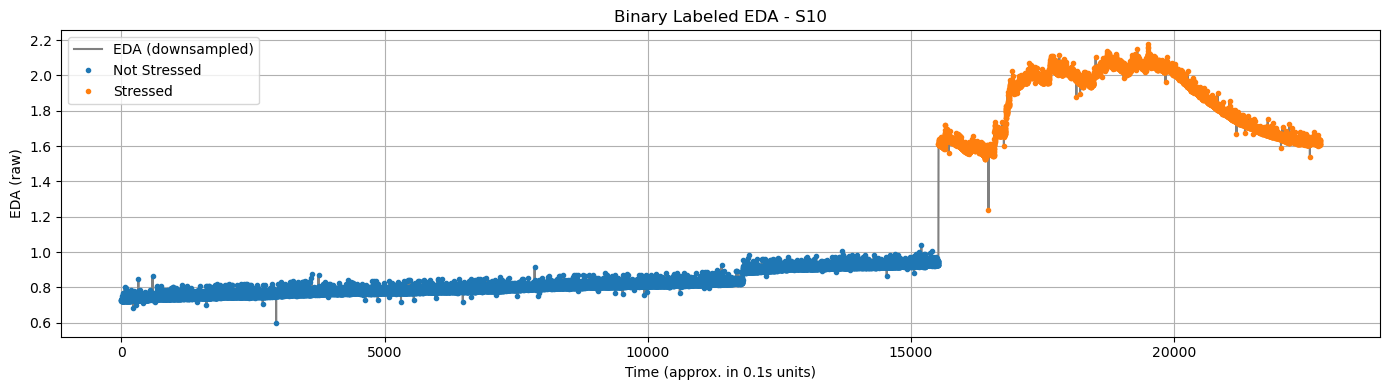

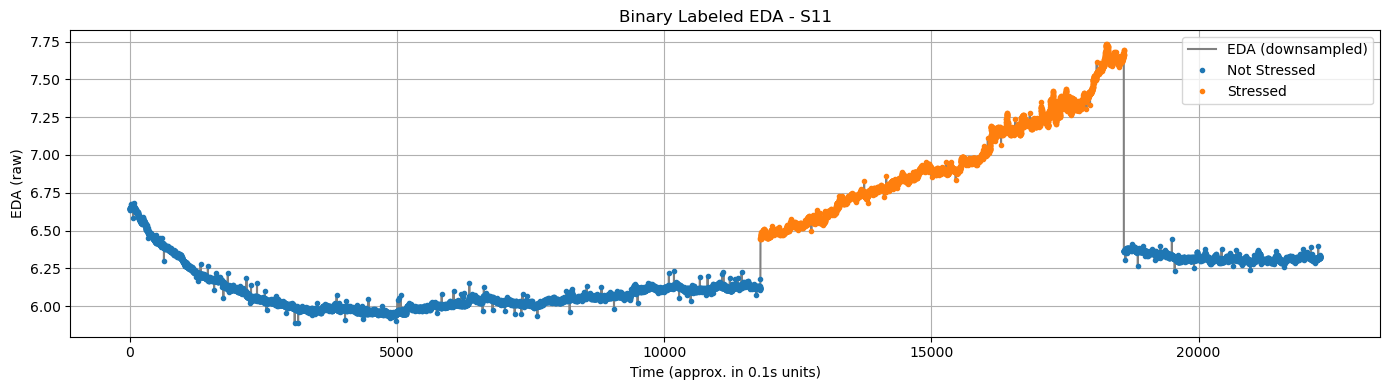

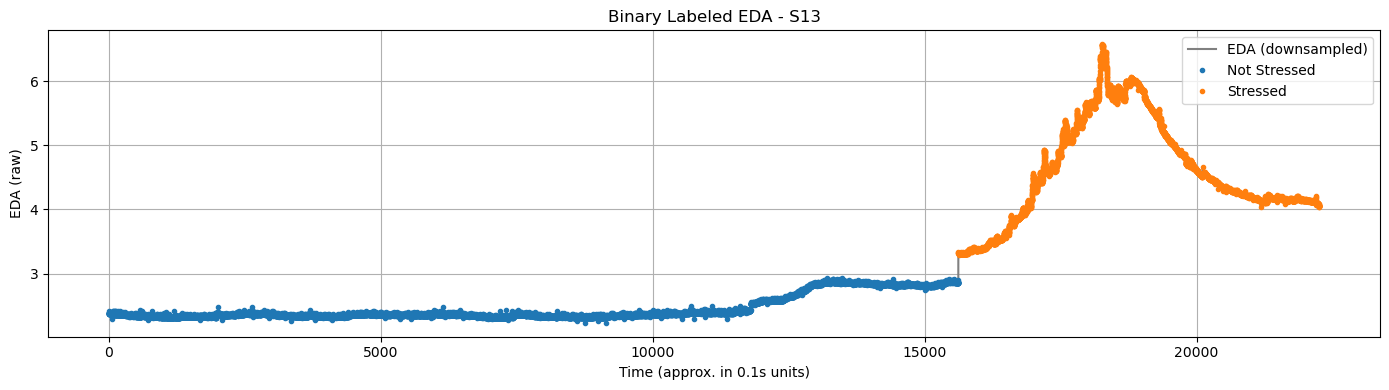

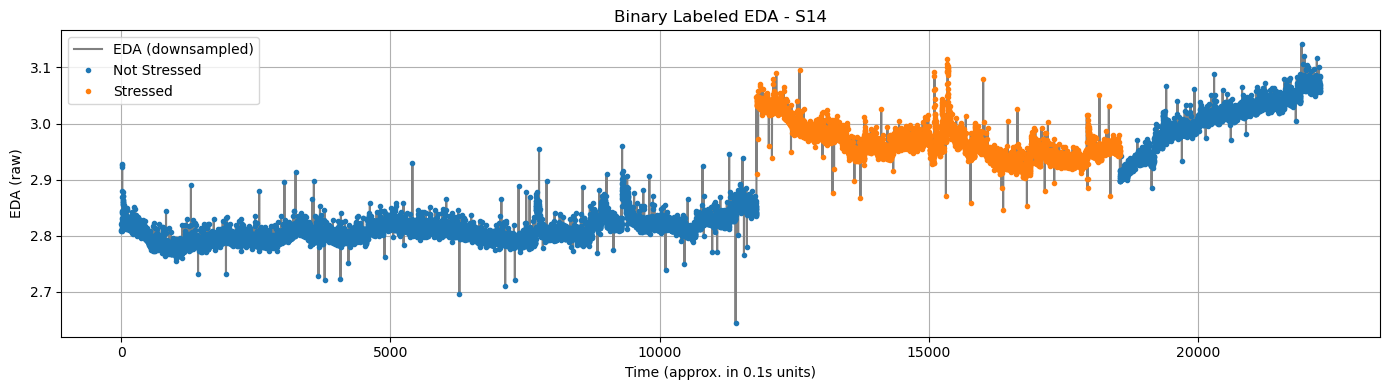

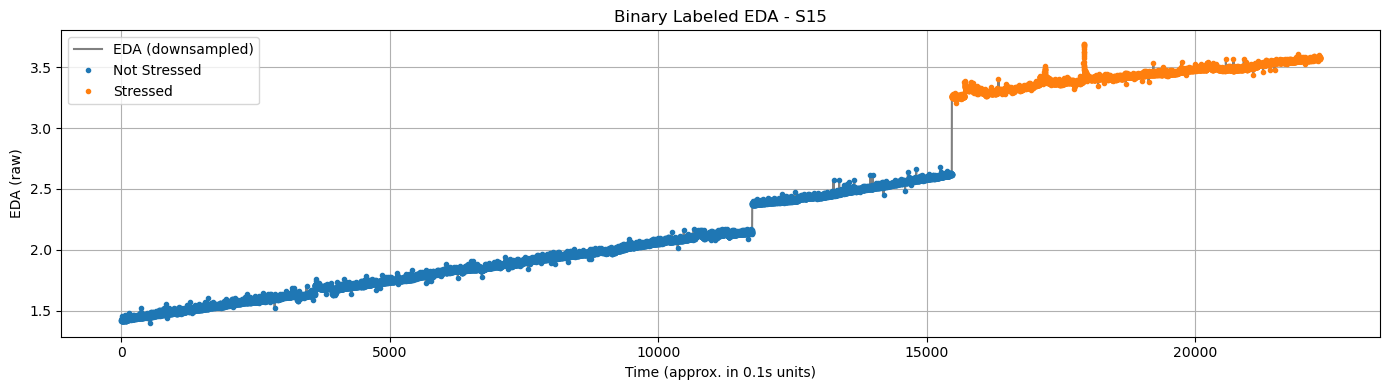

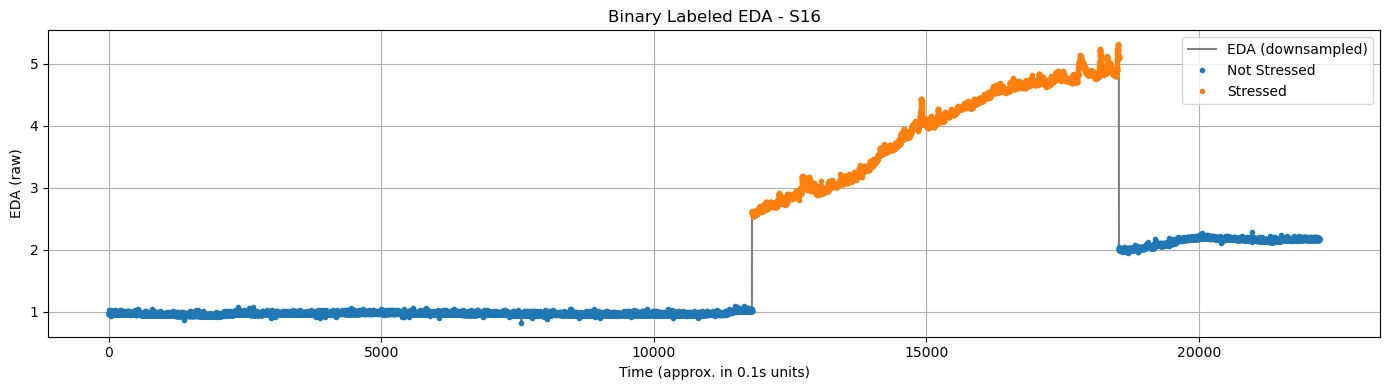

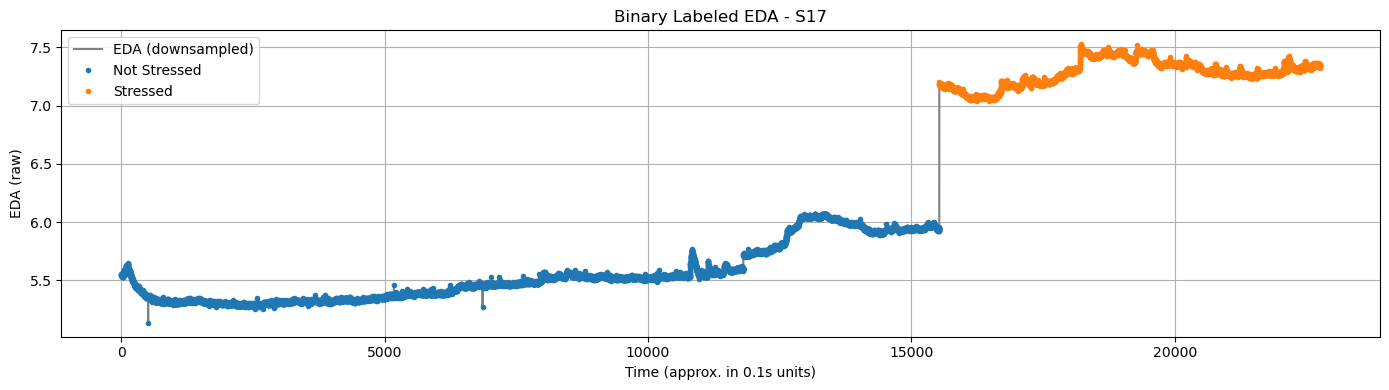

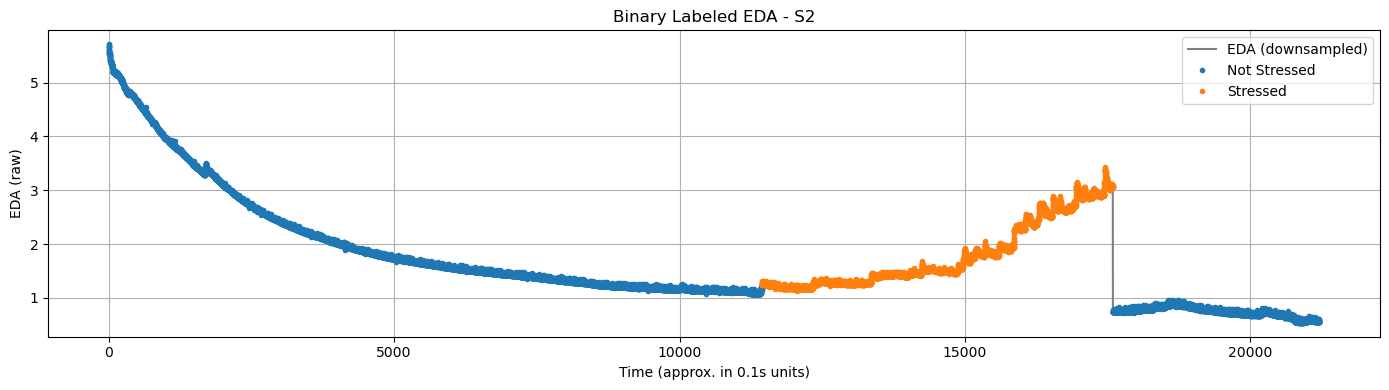

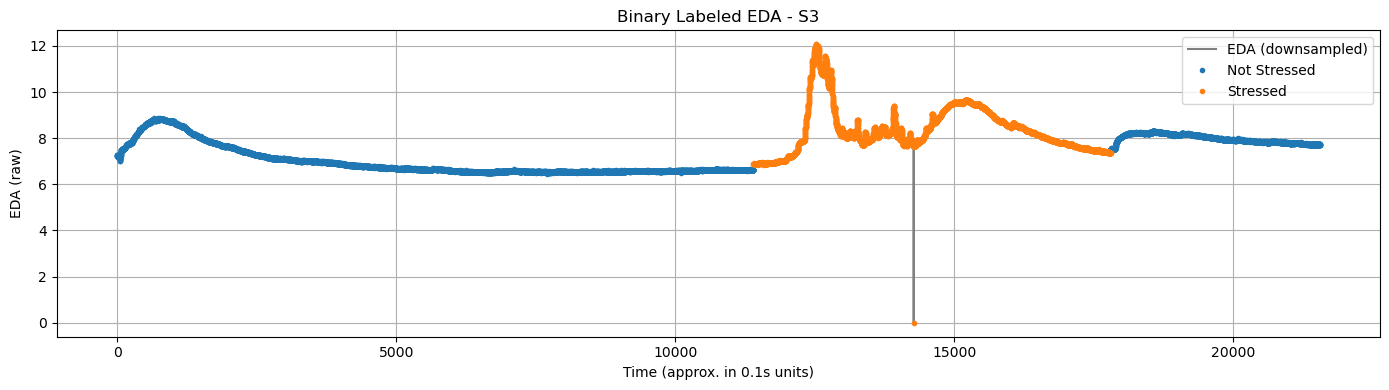

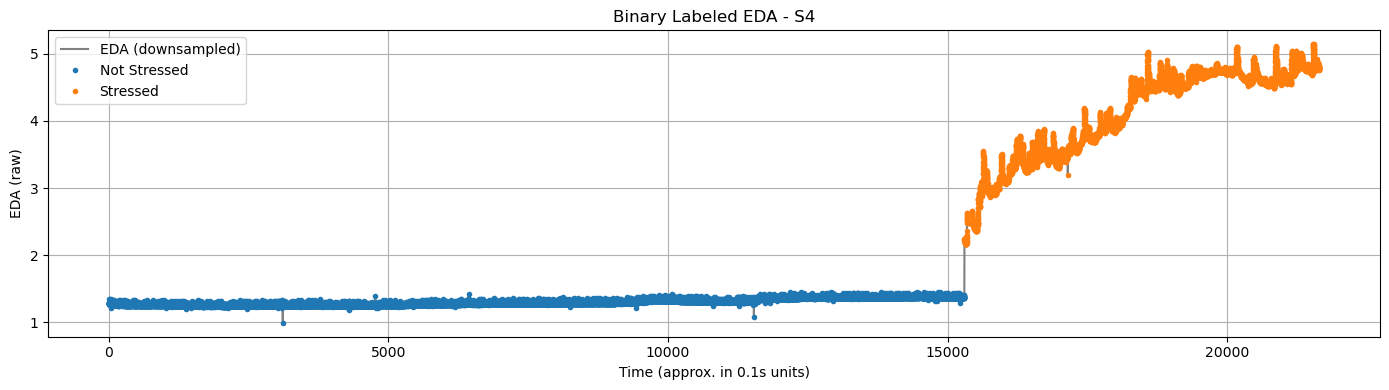

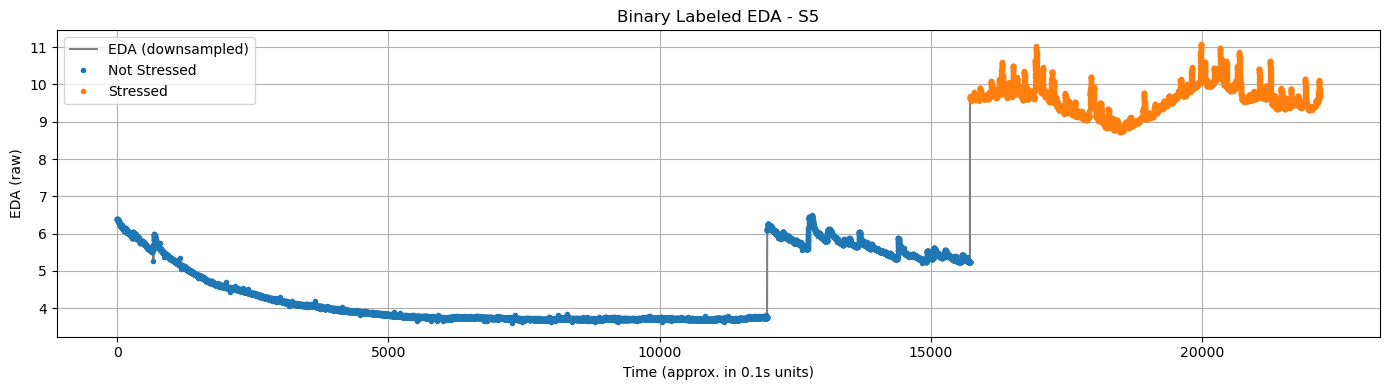

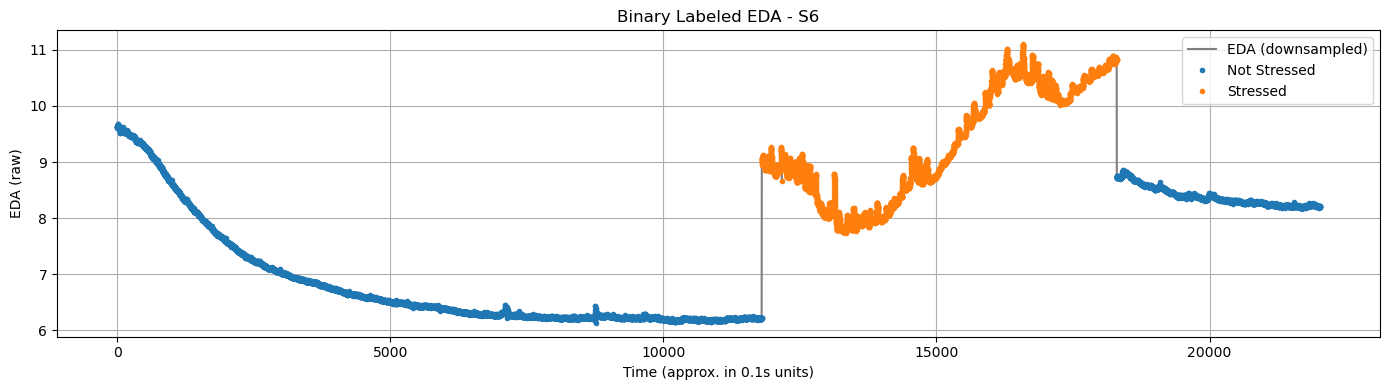

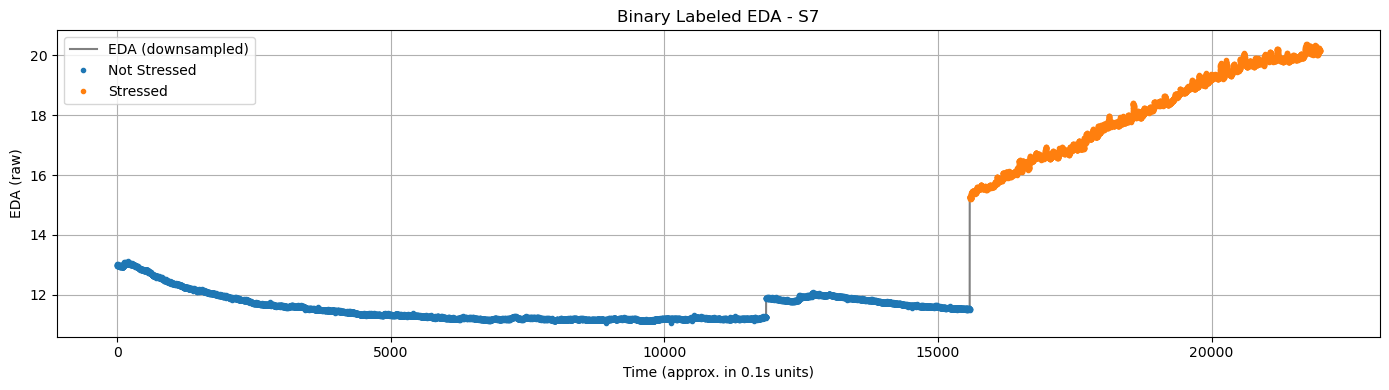

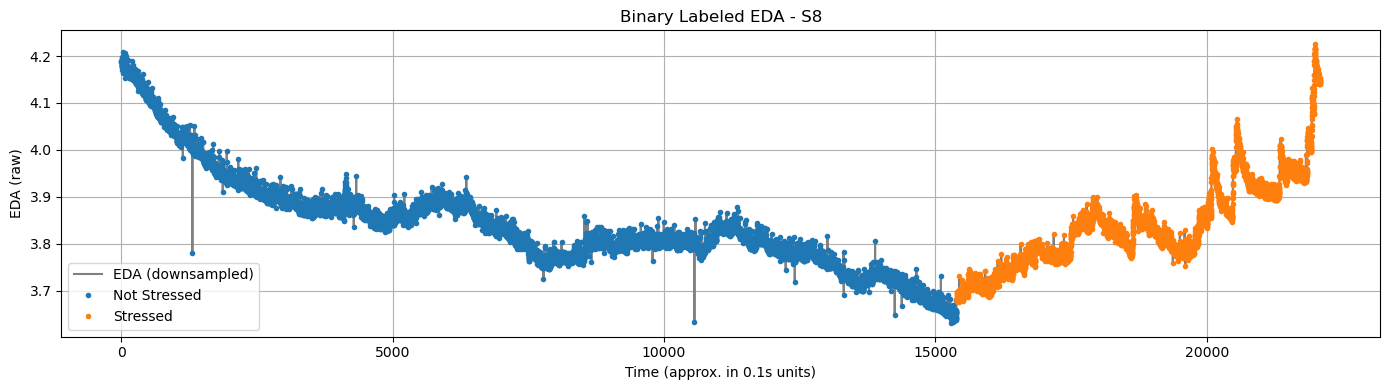

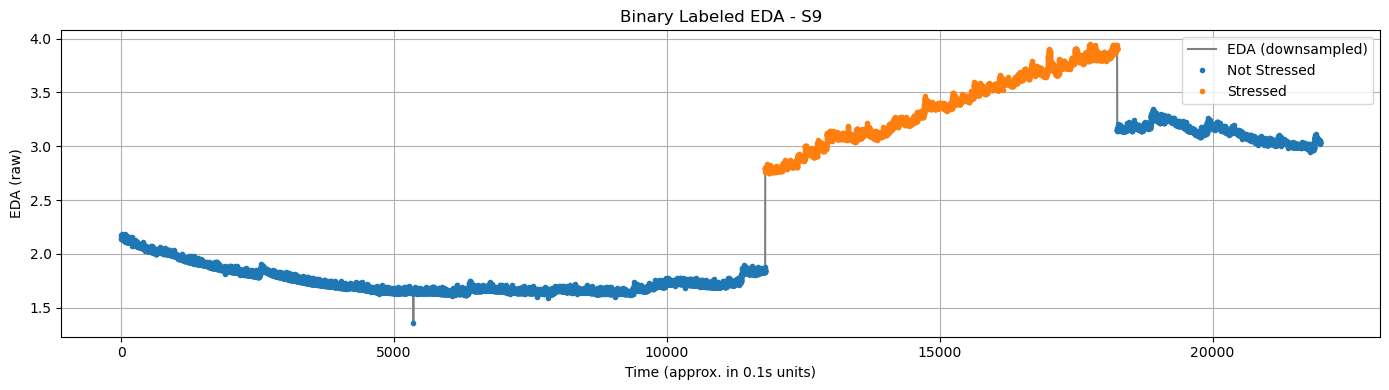

In [22]:
label_map_binary = {0: 'Not Stressed', 1: 'Stressed'}

for subject_id, data in cleaned_data_dict.items():
    eda = data['EDA']
    binary_labels = data['binary_label']

    # Downsample for visualization (~10Hz)
    step = 70
    eda_ds = eda[::step]
    labels_ds = binary_labels[::step]

    plt.figure(figsize=(14, 4))
    plt.plot(eda_ds, color='gray', label='EDA (downsampled)')

    for label_value in np.unique(labels_ds):
        idx = labels_ds == label_value
        plt.plot(np.where(idx)[0], eda_ds[idx], '.', label=label_map_binary[label_value])

    plt.title(f'Binary Labeled EDA - {subject_id}')
    plt.xlabel('Time (approx. in 0.1s units)')
    plt.ylabel('EDA (raw)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [23]:
for subject_id, data in cleaned_data_dict.items():
    eda_len = len(data['EDA'])
    label_len = len(data['binary_label'])

    if eda_len != label_len:
        print(f"{subject_id}: Mismatch! EDA: {eda_len}, Binary Label: {label_len}")
    else:
        print(f"{subject_id}: Length OK — {eda_len} samples")

S10: Length OK — 1593900 samples
S11: Length OK — 1559600 samples
S13: Length OK — 1558201 samples
S14: Length OK — 1558901 samples
S15: Length OK — 1563100 samples
S16: Length OK — 1554701 samples
S17: Length OK — 1593200 samples
S2: Length OK — 1484700 samples
S3: Length OK — 1508500 samples
S4: Length OK — 1515501 samples
S5: Length OK — 1551900 samples
S6: Length OK — 1541400 samples
S7: Length OK — 1538601 samples
S8: Length OK — 1546299 samples
S9: Length OK — 1537900 samples


Signal Segmentation

In [24]:
segment_length = 700 * 60  # 60 seconds
segments = []
labels = []

for subject_id, data in cleaned_data_dict.items():
    eda = data['EDA']
    binary_labels = data['binary_label']

    total_samples = len(eda)
    num_segments = total_samples // segment_length

    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length

        eda_segment = eda[start:end]
        label_segment = binary_labels[start:end]

        if np.all(label_segment == label_segment[0]):
            segments.append(eda_segment)
            labels.append(label_segment[0])

    print(f"{subject_id}: Segmented into {num_segments} windows")

print(f"\n✅ Total segments: {len(segments)}")

S10: Segmented into 37 windows
S11: Segmented into 37 windows
S13: Segmented into 37 windows
S14: Segmented into 37 windows
S15: Segmented into 37 windows
S16: Segmented into 37 windows
S17: Segmented into 37 windows
S2: Segmented into 35 windows
S3: Segmented into 35 windows
S4: Segmented into 36 windows
S5: Segmented into 36 windows
S6: Segmented into 36 windows
S7: Segmented into 36 windows
S8: Segmented into 36 windows
S9: Segmented into 36 windows

✅ Total segments: 525


In [25]:
segments = np.array(segments)
labels = np.array(labels)
print("Segment shape:", segments.shape)  # (num_segments, 42000)
print("Labels distribution:", np.bincount(labels))

Segment shape: (525, 42000)
Labels distribution: [373 152]


In [26]:
from collections import Counter

print("Label distribution:", Counter(labels))

Label distribution: Counter({0: 373, 1: 152})


Signal filteration and normalization

In [27]:
from biosppy.signals import eda
for subject_id, data in cleaned_data_dict.items():
    raw_eda = data['EDA']
    out = eda.eda(signal=raw_eda, sampling_rate=700.0, show=False)
    cleaned_data_dict[subject_id]['EDA'] = out['filtered']  
    print(f"{subject_id} EDA filtered")

S10 EDA filtered
S11 EDA filtered
S13 EDA filtered
S14 EDA filtered
S15 EDA filtered
S16 EDA filtered
S17 EDA filtered
S2 EDA filtered
S3 EDA filtered
S4 EDA filtered
S5 EDA filtered
S6 EDA filtered
S7 EDA filtered
S8 EDA filtered
S9 EDA filtered


In [28]:
for subject_id, data in cleaned_data_dict.items():
    eda_signal = data['EDA']
    eda_norm = (eda_signal - np.mean(eda_signal)) / np.std(eda_signal)
    cleaned_data_dict[subject_id]['EDA'] = eda_norm
    print(f"{subject_id} EDA normalized")

S10 EDA normalized
S11 EDA normalized
S13 EDA normalized
S14 EDA normalized
S15 EDA normalized
S16 EDA normalized
S17 EDA normalized
S2 EDA normalized
S3 EDA normalized
S4 EDA normalized
S5 EDA normalized
S6 EDA normalized
S7 EDA normalized
S8 EDA normalized
S9 EDA normalized


In [29]:
segment_length = 700 * 60  # 60 seconds
segments = []
labels = []
segment_subject_ids = []  # NEW: to track subject IDs

for subject_id, data in cleaned_data_dict.items():
    eda = data['EDA']
    binary_labels = data['binary_label']

    total_samples = len(eda)
    num_segments = total_samples // segment_length

    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length

        eda_segment = eda[start:end]
        label_segment = binary_labels[start:end]

        if np.all(label_segment == label_segment[0]):
            segments.append(eda_segment)
            labels.append(label_segment[0])
            segment_subject_ids.append(subject_id)  # Track origin

    print(f"{subject_id}: {len(segments)} valid segments (cumulative)")

S10: 36 valid segments (cumulative)
S11: 72 valid segments (cumulative)
S13: 108 valid segments (cumulative)
S14: 143 valid segments (cumulative)
S15: 179 valid segments (cumulative)
S16: 214 valid segments (cumulative)
S17: 250 valid segments (cumulative)
S2: 283 valid segments (cumulative)
S3: 317 valid segments (cumulative)
S4: 352 valid segments (cumulative)
S5: 387 valid segments (cumulative)
S6: 421 valid segments (cumulative)
S7: 456 valid segments (cumulative)
S8: 491 valid segments (cumulative)
S9: 525 valid segments (cumulative)


In [30]:
segments = np.array(segments)
labels = np.array(labels)

print("\n Final segmented data shape:", segments.shape)
print(" Label distribution:", dict(zip(*np.unique(labels, return_counts=True))))


 Final segmented data shape: (525, 42000)
 Label distribution: {0: 373, 1: 152}


In [ ]:
print(f"Segments: {len(segments)}")
print(f"Labels:   {len(labels)}")
print(f"Label sample: {labels[:5]}")

In [36]:
def segment_signal(signal, labels, window_size):
    segments = []
    segment_labels = []

    num_segments = len(signal) // window_size

    for i in range(num_segments):
        start = i * window_size
        end = start + window_size

        segment = signal[start:end]
        segment_label = labels[start:end]

        # Majority label for the segment
        label = int(np.round(np.mean(segment_label)))

        segments.append(segment)
        segment_labels.append(label)

    return segments, segment_labels

In [38]:
print("Subjects loaded:", list(cleaned_data_dict.keys()))

Subjects loaded: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']


Feature Extraction

In [40]:
def extract_statistical_features(signal):
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'range': np.max(signal) - np.min(signal)
    }
all_features = []

# Loop over all subjects
for subject_id, subject_data in cleaned_data_dict.items():
    eda = subject_data['EDA']
    labels = subject_data['binary_label']

    # Segment signal and labels
    window_size = 60 * 35  # Adjust as needed
    step_size = window_size  # No overlap
    num_segments = (len(eda) - window_size) // step_size + 1

    for i in range(num_segments):
        start = i * step_size
        end = start + window_size
        segment = eda[start:end]
        segment_label = np.bincount(labels[start:end]).argmax()  # Majority label in segment

        features = extract_statistical_features(segment)
        features['label'] = segment_label
        features['subject'] = subject_id

        all_features.append(features)

final_df = pd.DataFrame(all_features)


print("Final dataset shape:", final_df.shape)
print("Label distribution:\n", final_df['label'].value_counts())
print(final_df.head())

Final dataset shape: (11046, 7)
Label distribution:
 label
0    7726
1    3320
Name: count, dtype: int64
       mean       std       min       max     range  label subject
0 -0.837306  0.000607 -0.839413 -0.836360  0.003052      0     S10
1 -0.835394  0.000673 -0.837004 -0.833962  0.003042      0     S10
2 -0.834994  0.002614 -0.838934 -0.831987  0.006948      0     S10
3 -0.835462  0.001883 -0.838690 -0.832788  0.005902      0     S10
4 -0.834405  0.001261 -0.836958 -0.832166  0.004791      0     S10


In [42]:
print("Unique subjects:", final_df['subject'].unique())

Unique subjects: ['S10' 'S11' 'S13' 'S14' 'S15' 'S16' 'S17' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7'
 'S8' 'S9']


Modeling

Confusion Matrix:
[[1417  129]
 [ 100  564]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1546
           1       0.81      0.85      0.83       664

    accuracy                           0.90      2210
   macro avg       0.87      0.88      0.88      2210
weighted avg       0.90      0.90      0.90      2210



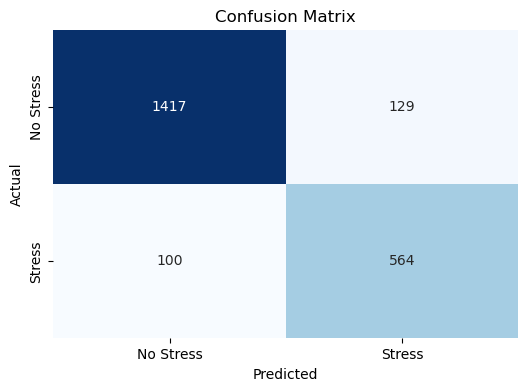

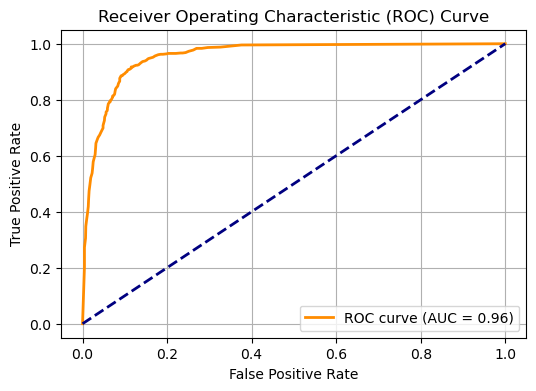

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split the dataS
X = final_df.drop(['label', 'subject'], axis=1)
y = final_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

SMOTE oversampling

Before SMOTE: {0: 6180, 1: 2656}
After SMOTE: {1: 6180, 0: 6180}
Confusion Matrix:
[[1365  181]
 [  65  599]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1546
           1       0.77      0.90      0.83       664

    accuracy                           0.89      2210
   macro avg       0.86      0.89      0.87      2210
weighted avg       0.90      0.89      0.89      2210



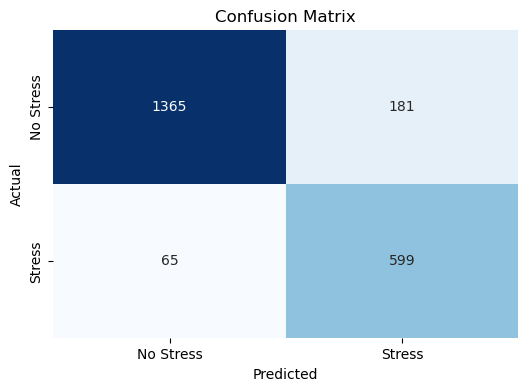

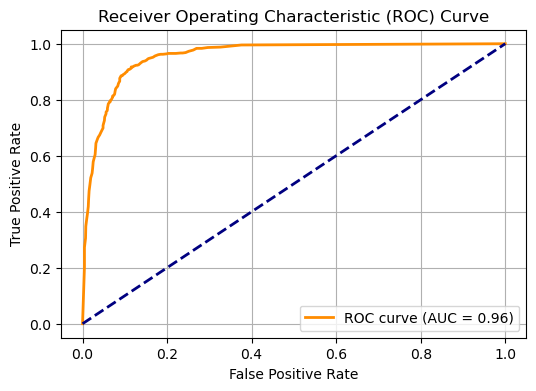

In [56]:
from imblearn.over_sampling import SMOTE
X = final_df.drop(columns=["label", "subject"])
y = final_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_smote).value_counts().to_dict())

# 4. Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_smote, y_smote)

# 5. Evaluate
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1236
           1       0.89      0.94      0.92      1236

    accuracy                           0.91      2472
   macro avg       0.92      0.91      0.91      2472
weighted avg       0.92      0.91      0.91      2472

Confusion Matrix:


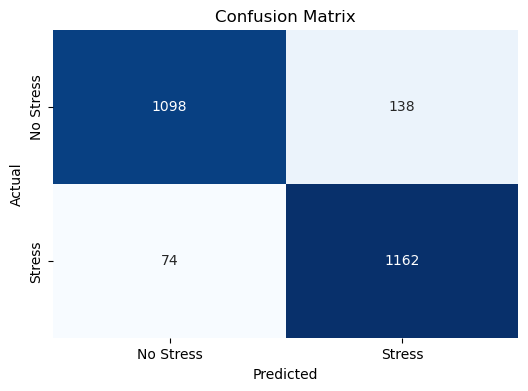

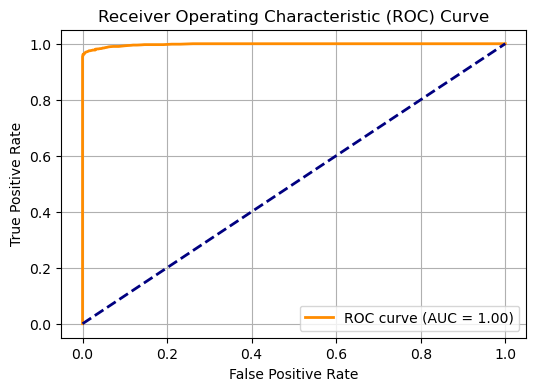

In [60]:
df_balanced = pd.DataFrame(X_smote, columns=X.columns)
df_balanced['label'] = y_smote
# Assuming your features and labels are in X_smote and y_smote from SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict
y_pred = rf_clf.predict(X_test)

# Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Cross-validation, hyper paremeter tuning

In [64]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracy scores:", scores)
print("Mean CV accuracy:", np.mean(scores))

Cross-validation accuracy scores: [0.89864253 0.89225894 0.89452241 0.89769126 0.89135355]
Mean CV accuracy: 0.8948937399244963


In [66]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
groups = final_df['subject']

scores = cross_val_score(model, X, y, cv=logo.split(X, y, groups=groups), scoring='accuracy')
print("LOSOCV accuracy mean:", np.mean(scores))

LOSOCV accuracy mean: 0.868454422535784


In [70]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_iter=20,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_res, y_train_res)
best_model = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [78]:
print(search.best_params_)
print(search.best_score_)

{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 30}
0.9376477858172722


In [80]:
best_model =search.best_estimator_

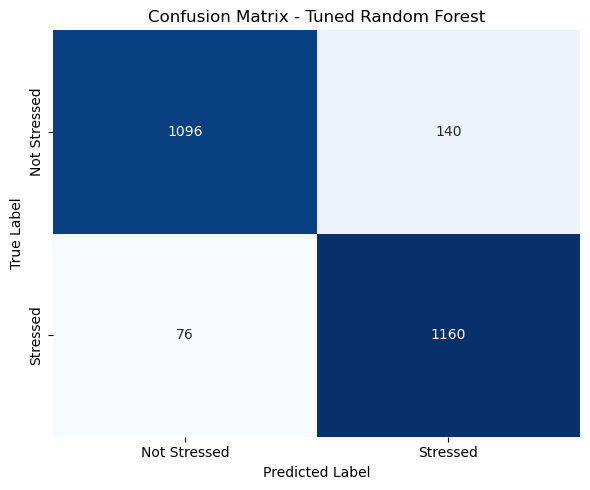

Classification Report:

              precision    recall  f1-score   support

Not Stressed       0.94      0.89      0.91      1236
    Stressed       0.89      0.94      0.91      1236

    accuracy                           0.91      2472
   macro avg       0.91      0.91      0.91      2472
weighted avg       0.91      0.91      0.91      2472



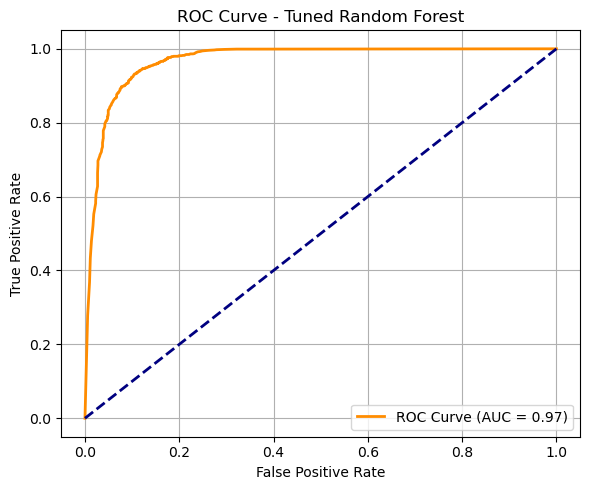

In [86]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # For ROC curve

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Stressed', 'Stressed'],
            yticklabels=['Not Stressed', 'Stressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Not Stressed", "Stressed"]))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
# Use the best model
best_model = search.best_estimator_

# Predict on test set
y_pred_test = best_model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

# Optional: ROC AUC if binary
if len(np.unique(y_test)) == 2:
    y_proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC Score:", auc)

[[1096  140]
 [  76 1160]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1236
           1       0.89      0.94      0.91      1236

    accuracy                           0.91      2472
   macro avg       0.91      0.91      0.91      2472
weighted avg       0.91      0.91      0.91      2472

ROC AUC Score: 0.9676846702485312
